# Programmierübung 1: Schreibkurs für Roboter

### Vorbereitung
Bitte installiere zunächst die benötigten Bibliotheken für diese Programmierübung. 
Dies kannst du tun, indem du mit deinem Terminal zunächst in das (entpackte) Verzeichnis dieser Programmierübung navigierst.
Dort solltest du neben diesem Notebook auch ein Verzeichnis "cer_pex1_lib" sehen.
Installiere dieses mittels
```bash
pip install ./cer_pex1_lib
```
Bei der Installation dieses Pakets werden alle in dieser Übung benötigten Pakete automatisch mitinstalliert.

### Module importieren
Hier importieren wir die benötigten Module für diese Programmierübung.
Bitte importiere keine weiteren Module, die hier aufgeführten sind ausreichend um die Aufgabe zu bearbeiten.

In [2]:
%matplotlib notebook
import math
import time
from typing import Tuple, List, Sequence
import numpy as np

import matplotlib
matplotlib.use("nbAgg")
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.axis import Axis

try:
    from cer_pex1 import RobotArm, test_almost_zero, test_geq, test_true
except ImportError:
    print("I did not find the cer_pex1 library. Please make sure you installed it via \"pip install /path/to/cer_pex1_lib\".")
    raise

## 1. Analytische Lösung der Vorwärtskinematik

In [3]:
def compute_forward_kinematics_analytical(q: np.ndarray, l: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Computes the forward kinematics of a robot with a two link arm, parameterized by joint angles q and link lengths l.
    :param q: 2D numpy array containing the joint angles in radians.
    :param l: 2D numpy array containing the link length in meters.
    :return: A tuple (p1, p2), where p1 is the 2D position of the elbow and p2 is the position of the end effector.
    """
    # Implement this...
    p1x = math.cos(q[0])*l[0]
    p1y = math.sin(q[0])*l[0]
    p1 = np.array([p1x,p1y])
    p2 = np.array([p1x + math.cos(q[0]+q[1])*l[1],p1y + math.sin(q[0]+q[1])*l[1]])
    return p1, p2


### Arme und Visualisierung aufsetzen

In [4]:
def setup_axes(count: int) -> Tuple[plt.Figure, Sequence[Axis]]:
    # Feel free to adapt these settings to better match your liking
    columns = min(3, count)
    rows = int(np.ceil(count / 3))
    plt.rcParams["figure.figsize"] = [9.8, 4 * rows]
    plt.rcParams["figure.autolayout"] = True
    fig, axes = plt.subplots(rows, columns, squeeze=False)
    fig.tight_layout()

    # Initialize all three arms
    for i, ax in enumerate(axes.reshape(-1)):
        # Setup axes for visualization
        ax.set_title("Arm {}".format(i))
        ax.set_xlim(-1.3, 1.3)
        ax.set_ylim(-1.5, 1.5)
        ax.set_aspect("equal")
        ax.xaxis.set_major_locator(MultipleLocator(0.4))
        ax.yaxis.set_major_locator(MultipleLocator(0.4))
        ax.xaxis.set_minor_locator(MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.2))
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.yaxis.set_label_coords(-0.15, 0.5)
        ax.grid()
        ax.grid(which="minor")
    return fig, axes.reshape((-1,))[:count]

### Öffentliche Tests
In diesem Test und den meisten folgenden sind die Testfälle durch ein Array `test_cases` definiert.
Jeder Eintrag des Arrays ist ein Tupel `(input, output)`, wobei `input` die Eingabe der Funktion ist und `output` die erwartete Ausgabe.

Zusätzlich visualisieren wir manche der Tests.
Hier gibt der dunkle, transparente Arm die Zielpose des jeweiligen Tests an.
Liegen die beiden Arme direkt übereinander, ist der Test bestanden.

<IPython.core.display.Javascript object>


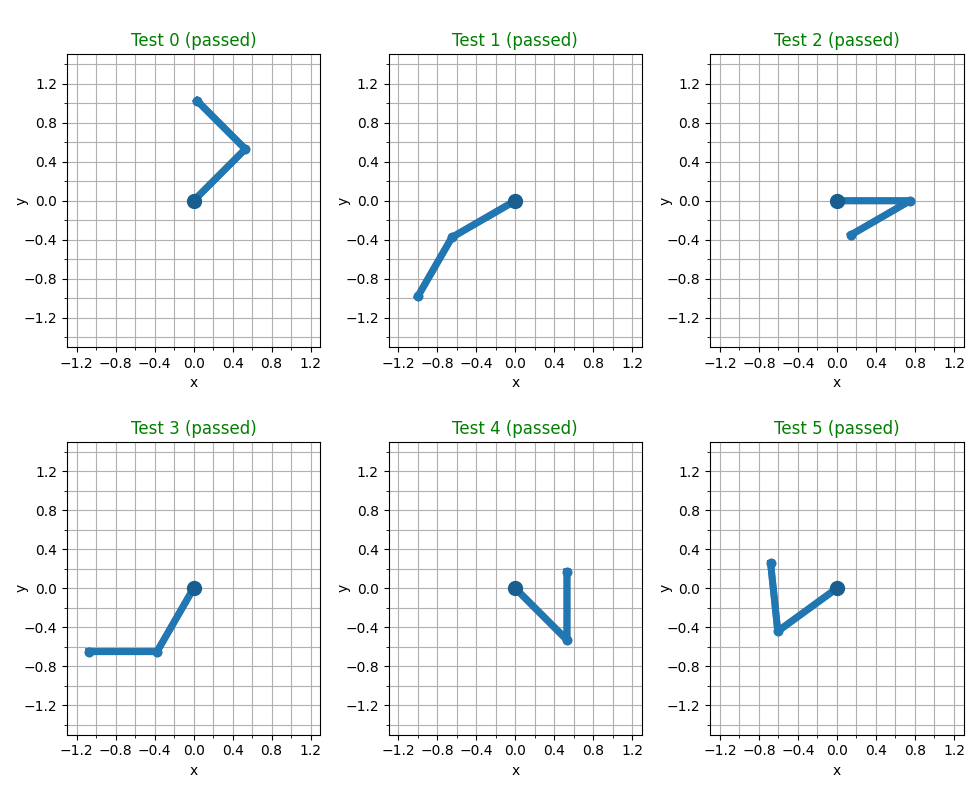

In [5]:
test_cases = [
    ([np.pi / 4, np.pi / 2],             ([0.53033, 0.53033],     [0.035355, 1.025305])),
    ([-5 / 6 * np.pi, np.pi / 6],        ([-0.649519, -0.375000], [-0.999519, -0.981218])),
    ([0.0, -5 / 6 * np.pi],              ([0.75, 0.0],            [0.143782, -0.35])),
    ([-2 / 3 * np.pi, - 1 / 3 * np.pi],  ([-0.375, -0.649519],    [-1.075, -0.649519])),
    ([-0.25 * np.pi, 0.75 * np.pi],      ([0.53033, -0.53033],    [0.53033, 0.16967])),
    ([3.2 * np.pi, - 2 / 3 * np.pi],     ([-0.606763, -0.440839], [-0.679933, 0.255326]))
]
l = np.array([0.75, 0.7])

fig, axes = setup_axes(len(test_cases))
for i, (ax, (q, (p1_tar, p2_tar))) in enumerate(zip(axes, test_cases)):
    # Plot target arm pose in transparent black
    ax.plot([0.0, p1_tar[0], p2_tar[0]], [0.0, p1_tar[1], p2_tar[1]], linewidth=5.0, marker="o", color=(0, 0, 0, 0.5))
    
    # Compute pose using your method
    p1, p2 = compute_forward_kinematics_analytical(np.array(q), l)
    
    # Plot your arm pose in blue
    ax.plot([0.0, p1[0], p2[0]], [0.0, p1[1], p2[1]], linewidth=5.0, marker="o", color="#1f77b4")
    # Make the arm base bigger and darker
    ax.plot([0.0], [0.0], marker="o", color="#185f90", markersize=10)
    
    if np.linalg.norm(p1 - p1_tar) < 1e-4 and np.linalg.norm(p2 - p2_tar) < 1e-4:
        ax.set_title("Test {} (passed)".format(i), color="green")
    else:
        ax.set_title("Test {} (failed)".format(i), color="red")


## 2. Aufstellen einer Transformationsmatrix aus DH-Parametern

In [6]:
def compute_transformation_dh(theta: float, d: float, a: float, alpha: float) -> np.ndarray:
    """
    Generates a transformation matrix out of DH parameters.
    :param theta:   Scalar DH parameter theta.
    :param d:       Scalar DH parameter d.
    :param a:       Scalar DH parameter a.
    :param alpha:   Scalar DH parameter alpha.
    :return: A 4x4 numpy array containing the transformation matrix.
    """
    # Implement this...
    arr = np.array([[math.cos(theta) , -math.sin(theta)*math.cos(alpha) , math.sin(theta)*math.sin(alpha) , a*math.cos(theta)],
                    [math.sin(theta) , math.cos(theta)*math.cos(alpha) , -math.cos(theta)*math.sin(alpha) , a*math.sin(theta)],
                    [0 , math.sin(alpha) , math.cos(alpha) , d],
                    [0,0,0,1]])
    return arr


### Öffentliche Tests

In [7]:
test_cases = [
    ((0., 0., 0.75, 0.),                [[1.0, 0.0, 0., 0.75], 
                                         [0., 1.0, 0.0, 0.], 
                                         [0., 0., 1.0, 0.], 
                                         [0., 0., 0., 1.0]]),
    
    ((1 / 6 * np.pi, 0., 0.75, 0.),     [[0.866025, -0.5, 0., 0.649519], 
                                         [0.5, 0.866025, -0.0, 0.375], 
                                         [0., 0., 1.0, 0.], 
                                         [0., 0., 0., 1.0]]),
    
    ((2 * np.pi, 0., 0.7, 0.),          [[1.0, 0., 0.0, 0.7], 
                                         [0.0, 1.0, 0.0, 0.0], 
                                         [0., 0., 1.0, 0.], 
                                         [0., 0., 0., 1.0]]),
    
    ((3.7 * np.pi, 0., 0.7, 0.),        [[0.587785, 0.809017, 0.0, 0.41145], 
                                         [-0.809017, 0.587785, 0.0, -0.566312], 
                                         [0., 0., 1.0, 0.], 
                                         [0., 0., 0., 1.0]]),
    
    ((np.pi / 2, -1.0, 0.1, np.pi / 3), [[0., -0.5, 0.866025, 0.], 
                                         [1.0, 0., 0.0, 0.1], 
                                         [0., 0.866025, 0.5, -1.0], 
                                         [0., 0., 0., 1.0]]),
    
    ((0., 0., 0., 0.),                  [[1.0, 0.0, 0., 0.], 
                                         [0., 1.0, 0.0, 0.], 
                                         [0., 0., 1.0, 0.], 
                                         [0., 0., 0., 1.0]])]

for i, ((theta, d, a, alpha), target) in enumerate(test_cases):
    # Execute your function
    matrix = compute_transformation_dh(theta, d, a, alpha)
    
    # Compare with target
    test_almost_zero(i, np.linalg.norm(matrix - target))

Test 0: passed.
Test 1: passed.
Test 2: passed.
Test 3: passed.
Test 4: passed.
Test 5: passed.


## 3. Berechnung der Vorwärtskinematik mittels DH-Transformationen

In [8]:
def compute_forward_kinematics_dh(q: np.ndarray, l: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Using the compute_transformation_dh function, computes the forward kinematics of a robot with a two link arm,
    parameterized by joint angles q and link lengths l.
    :param q: 2D numpy array containing the joint angles in radians.
    :param l: 2D numpy array containing the link length in meters.
    :return: A tuple (p1, p2), where p1 is the 2D position of the elbow and p2 is the position of the end effector.
    """
    # Implement this...
    T01 = compute_transformation_dh(q[0],0,l[0],0)
    T12 = compute_transformation_dh(q[1],0,l[1],0)
    T02 = np.zeros((4,4))
    for i in range(len(T01)):
        for j in range(len(T12[0])):
            for k in range(len(T12)):
                T02[i][j] = T02[i][j]+T01[i][k]*T12[k][j]
                
    arr1 = np.array([T01[0][3] , T01[1][3]])
    arr2 = np.array([T02[0][3] , T02[1][3]])      
    return  arr1,arr2


### Öffentliche Tests

<IPython.core.display.Javascript object>


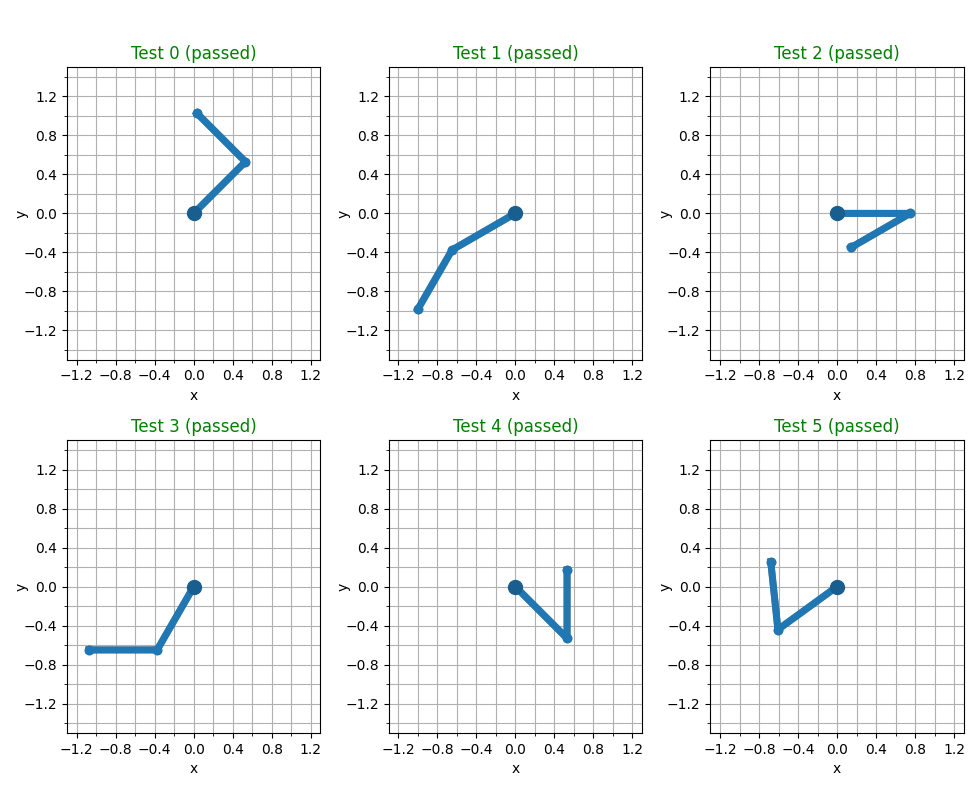

In [9]:
test_cases = [
    ([np.pi / 4, np.pi / 2],             ([0.53033, 0.53033],     [0.035355, 1.025305])),
    ([-5 / 6 * np.pi, np.pi / 6],        ([-0.649519, -0.375],    [-0.999519, -0.981218])),
    ([0.0, -5 / 6 * np.pi],              ([0.75, 0.0],            [0.143782, -0.35])),
    ([-2 / 3 * np.pi, - 1 / 3 * np.pi],  ([-0.375, -0.649519],    [-1.075, -0.649519])),
    ([-0.25 * np.pi, 0.75 * np.pi],      ([0.53033, -0.53033],    [0.53033, 0.16967])),
    ([3.2 * np.pi, - 2 / 3 * np.pi],     ([-0.606763, -0.440839], [-0.679933, 0.255326]))
]
l = np.array([0.75, 0.7])
fig, axes = setup_axes(len(test_cases))
for i, (ax, (q, (p1_tar, p2_tar))) in enumerate(zip(axes, test_cases)):
    # Plot target arm pose in transparent black
    ax.plot([0.0, p1_tar[0], p2_tar[0]], [0.0, p1_tar[1], p2_tar[1]], linewidth=5.0, marker="o", color=(0, 0, 0, 0.5))
    
    # Compute pose using your function
    p1, p2 = compute_forward_kinematics_dh(np.array(q), l)
    
    # Plot your arm pose in blue
    ax.plot([0.0, p1[0], p2[0]], [0.0, p1[1], p2[1]], linewidth=5.0, marker="o", color="#1f77b4")
    # Make the arm base bigger and darker
    ax.plot([0.0], [0.0], marker="o", color="#185f90", markersize=10)
    
    if np.linalg.norm(p1 - p1_tar) < 1e-4 and np.linalg.norm(p2 - p2_tar) < 1e-4:
        ax.set_title("Test {} (passed)".format(i), color="green")
    else:
        ax.set_title("Test {} (failed)".format(i), color="red")
    fig.canvas.draw()
    

## 4. Berechnung der inversen Kinematik mittels einfacher Fixpunktiteration

In [10]:
def compute_inverse_kinematics_fpi(target_ee_pos: np.ndarray, l: np.ndarray, q0: np.ndarray):
    """
    Compute the inverse kinematics of the two link robot via fixed point iteration
    :param target_ee_pos:   A 2D numpy array containing the target position of the end effector in meters.
    :param l:               A 2D numpy array containing the link lengths of the arm in meters.
    :param q0:              A 2D numpy array containing the initial solution for the FPI in radians.
    :return: A 2D numpy array containing the resulting joint angles in radians.
    """
    # Implement this...
    qx=np.zeros(2)
    abstand = np.zeros(2)
    qx[0] = q0[0]
    qx[1] = q0[1]
    index = 0

    while index<10000:
        Fx0 = target_ee_pos[0] - compute_forward_kinematics_dh(qx,l)[1][0]
        Fx1 = target_ee_pos[1] - compute_forward_kinematics_dh(qx,l)[1][1]
        if (Fx0**2 + Fx1**2)**0.5 < 0.00001:
            break
        qx[0] = 0.01*Fx0 + qx[0]
        qx[1] = 0.01*Fx1 + qx[1]
        index += 1

    return qx


### Öffentliche Tests

<IPython.core.display.Javascript object>


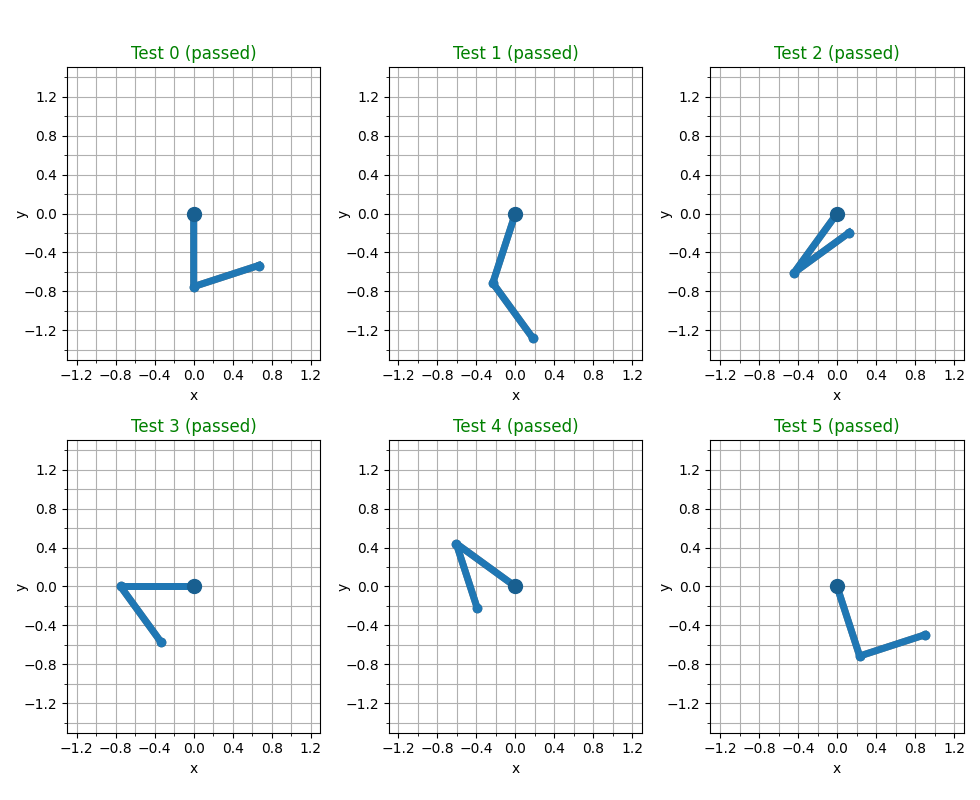

In [11]:
test_cases = [
    (([0.66574, -0.533688],   [-0.3 * np.pi, 0.9 * np.pi]), [-0.5 * np.pi, 0.6 * np.pi]),
    (([0.179687, -1.279604],  [-0.1 * np.pi, 0.1 * np.pi]), [-0.6 * np.pi, 0.3 * np.pi]),
    (([0.125473, -0.195313],  [-0.5 * np.pi, 0.3 * np.pi]), [-0.7 * np.pi, 0.9 * np.pi]),
    (([-0.33855, -0.566312],  [-0.6 * np.pi, 0.7 * np.pi]), [-1.0 * np.pi, 0.7 * np.pi]),
    (([-0.390451, -0.224901], [-0.4 * np.pi, 0.6 * np.pi]), [-1.2 * np.pi, 0.8 * np.pi]),
    (([0.897502, -0.49698],   [-0.2 * np.pi, 0.2 * np.pi]), [-0.4 * np.pi, 0.5 * np.pi])]
l = np.array([0.75, 0.7])    

fig, axes = setup_axes(len(test_cases))
for i, (ax, ((target_ee_pos, q0), q_tar)) in enumerate(zip(axes, test_cases)):
    # From here on, we use the RobotArm class to visualize the robot. It uses your kinematics model internally,
    # so make sure to implement it correctly to get a sensible visualization.
    arm = RobotArm(fig, ax, l, compute_forward_kinematics_analytical)
    
    # Execute your function
    q = compute_inverse_kinematics_fpi(np.array(target_ee_pos), l, np.array(q0))
    
    # Set the "shadow" arm to indicate the correct robot pose
    arm.set_shadow(q_tar)
    
    # Set the robot joint angles to your computed joint angles
    arm.set_joint_pos(q)
    
    if np.linalg.norm(q - q_tar) < 1e-4:
        ax.set_title("Test {} (passed)".format(i), color="green")
    else:
        ax.set_title("Test {} (failed)".format(i), color="red")
    fig.canvas.draw()
        

### Einfach Fixpunktiteration konvergiert nicht an allen Punkten...
Wir zeigen hier einige Beispiele, in denen die einfache Fixpunktiteration nicht konvergiert. **Wichtig**: es handelt sich hierbei nicht um bepunktete Tests, sondern um Beispiele die zeigen sollen dass die Fixpunktiteration nicht immer funktioniert.

<IPython.core.display.Javascript object>


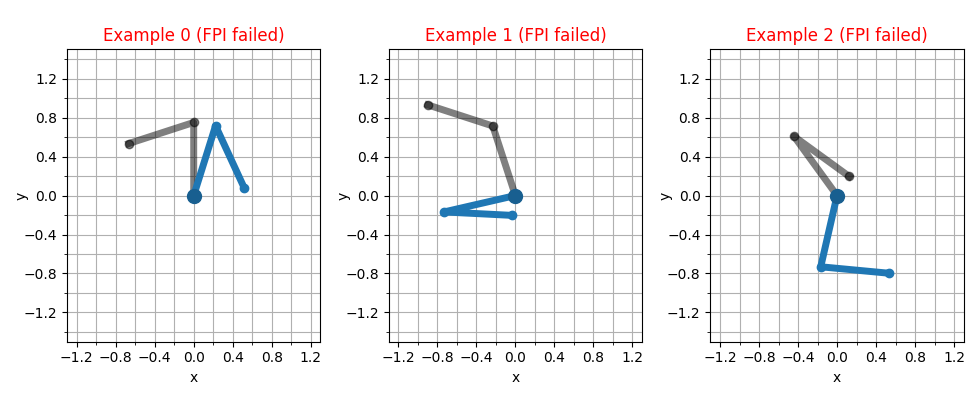

In [12]:
test_cases = [
    (([-0.66574, 0.533688],  [0.3 * np.pi, 0.9 * np.pi]),  [0.5 * np.pi, 0.6 * np.pi]),
    (([-0.897502, 0.929604], [0.1 * np.pi, 0.1 * np.pi]),  [0.6 * np.pi, 0.3 * np.pi]),
    (([0.125473, 0.195313],  [0.5 * np.pi, -0.3 * np.pi]), [0.7 * np.pi, -0.9 * np.pi])]
l = np.array([0.75, 0.7])    

fig, axes = setup_axes(len(test_cases))
for i, (ax, ((target_ee_pos, q0), q_tar)) in enumerate(zip(axes, test_cases)):
    # Create robot arm with your kinematics model
    arm = RobotArm(fig, ax, l, compute_forward_kinematics_analytical)
    
    # Execute your function
    q = compute_inverse_kinematics_fpi(np.array(target_ee_pos), l, np.array(q0))
    
    # Set the "shadow" arm to indicate the correct robot pose
    arm.set_shadow(q_tar)
    
    # Set the robot joint angles to your computed joint angles
    arm.set_joint_pos(q)
    
    if np.linalg.norm(q - q_tar) < 1e-4:
        # You should not see this case unless you fiddled with the relaxation matrix (which 
        # you should not do in the version you hand in)
        ax.set_title("Example {} (FPI succeeded)".format(i), color="green")
    else:
        ax.set_title("Example {} (FPI failed)".format(i), color="red")
    fig.canvas.draw()

## 5. Berechnung der Jacobi-Matrix der Vorwärtskinematik

In [13]:
def compute_jacobian(q: np.ndarray, l: np.ndarray) -> np.ndarray:
    """
    Computes the Jacobian (first derivative) of the forward kinematics of the robot arm.
    :param q: 2D numpy array containing the joint angles in radians.
    :param l: 2D numpy array containing the link length in meters.
    :return: A 2x2 numpy array containing the Jacobian.
    """
    # Implement this...
    j = np.array([[-l[0]*np.sin(q[0])-l[1]*np.sin(q[0]+q[1]), -l[1]*np.sin(q[0]+q[1])], 
                  [l[0]*np.cos(q[0])+l[1]*np.cos(q[0]+q[1]), l[1]*np.cos(q[0]+q[1])]])
    return j


### Öffentliche Tests

In [14]:
test_cases = [
    ([1 / 4 * np.pi, np.pi / 2],        [[-1.025305, -0.494975], 
                                         [0.035355, -0.494975]]),
    
    ([-5 / 6 * np.pi, np.pi / 6],       [[0.981218, 0.606218], 
                                         [-0.999519, -0.35]]),
    
    ([0.0, -5 / 6 * np.pi],             [[0.35, 0.35], 
                                         [0.143782, -0.606218]]),
    
    ([-2 / 3 * np.pi, - 1 / 3 * np.pi], [[0.649519, 0.], 
                                         [-1.075, -0.7]]),
    
    ([-0.25 * np.pi, 0.75 * np.pi],     [[-0.16967, -0.7], 
                                         [0.53033, 0.]]),
    
    ([3.2 * np.pi, - 2 / 3 * np.pi],    [[-0.255326, -0.696165], 
                                         [-0.679933, -0.07317]])]
l = np.array([0.75, 0.7])


for i, (q, jac_tar) in enumerate(test_cases):
    # Execute your function
    jac = compute_jacobian(np.array(q), l)
    
    test_almost_zero(i, np.linalg.norm(jac - jac_tar))


Test 0: passed.
Test 1: passed.
Test 2: passed.
Test 3: passed.
Test 4: passed.
Test 5: passed.


## 6. Berechnung inversen Kinematik mittels Newtonverfahren

In [19]:
def compute_inverse_kinematics_newton(target_ee_pos: np.ndarray, l: np.ndarray, q0: np.ndarray):
    """
    Compute the inverse kinematics of the two link robot via the Newton method
    :param target_ee_pos:   A 2D numpy array containing the target position of the end effector in meters.
    :param l:               A 2D numpy array containing the link lengths of the arm in meters.
    :param q0:              A 2D numpy array containing the initial solution for the Newton method in radians.
    :return: A 2D numpy array containing the resulting joint angles in radians.
    """
    # Implement this...
    def f(q:np.ndarray)->np.ndarray:
        return np.array(np.subtract(target_ee_pos, compute_forward_kinematics_analytical(q, l)[1]))
    q = q0
    for x in range(10000):
        d = np.linalg.solve(compute_jacobian(q, l), -1*f(q))
        q = q - np.dot(0.01, d)
        if np.sqrt(np.power(l[0]*np.cos(q[0])+l[1]*np.cos(q[0]+q[1])-target_ee_pos[0], 2)+np.power(l[0]*np.sin(q[0])+l[1]*np.sin(q[0]+q[1])-target_ee_pos[1], 2))<0.00001:
            break
    return q


### Öffentliche Tests

<IPython.core.display.Javascript object>


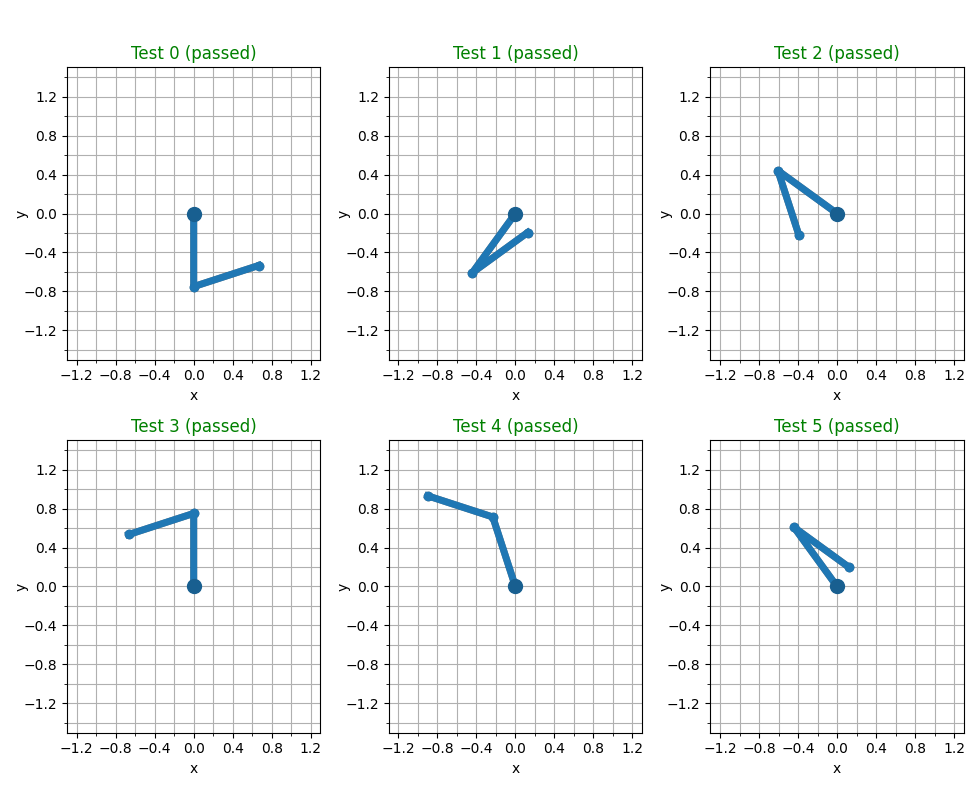

In [20]:
test_cases = [
    (([0.66574, -0.533688],   [-0.3 * np.pi, 0.9 * np.pi]), [-0.5 * np.pi, 0.6 * np.pi]),
    (([0.125473, -0.195313],  [-0.5 * np.pi, 0.3 * np.pi]), [-0.7 * np.pi, 0.9 * np.pi]),
    (([-0.390451, -0.224901], [-0.4 * np.pi, 0.6 * np.pi]), [-1.2 * np.pi, 0.8 * np.pi]),
    (([-0.66574, 0.533688],  [0.3 * np.pi, 0.9 * np.pi]),  [0.5 * np.pi, 0.6 * np.pi]),
    (([-0.897502, 0.929604], [0.1 * np.pi, 0.1 * np.pi]),  [0.6 * np.pi, 0.3 * np.pi]),
    (([0.125473, 0.195313],  [0.5 * np.pi, -0.3 * np.pi]), [0.7 * np.pi, -0.9 * np.pi])]
# Note that the last three test cases are exactly those in which FPI failed previously
l = np.array([0.75, 0.7])    

fig, axes = setup_axes(len(test_cases))
for i, (ax, ((target_ee_pos, q0), q_tar)) in enumerate(zip(axes, test_cases)):
    # Create robot arm with your kinematics model
    arm = RobotArm(fig, ax, l, compute_forward_kinematics_analytical)
    
    # Execute your function
    q = compute_inverse_kinematics_newton(np.array(target_ee_pos), l, np.array(q0))
    
    # Set the "shadow" arm to indicate the correct robot pose
    arm.set_shadow(q_tar)
    
    # Set the robot joint angles to your computed joint angles
    arm.set_joint_pos(q)
    
    if np.linalg.norm(q - q_tar) < 1e-4:
        ax.set_title("Test {} (passed)".format(i), color="green")
    else:
        ax.set_title("Test {} (failed)".format(i), color="red")
    fig.canvas.draw()

## 7.  Bestimmung der Eckkoordinaten der Buchstaben

In [21]:
def get_letter_print_path(letter: str) -> List[Tuple[Tuple[float, float], bool]]:
    """
    Given a letter, generates the path to print it.
    :param letter: String containing a single letter (either "I", "A", or "S").
    :return: A list of print coordinates. Each entry of the list is a tuple (p, e),
    where p is a 2D coordinate where the robot should move and e is a boolean indicating
    whether the robot should print on the way to the coordinate.

    Example:
        [((0.0, 0.0), False),
         ((0.0, 1.0), True),
         ((1.0, 1.0), False),
         ((1.0, 0.0), True))]
    In this example, the robot would first move to coordinate (0.0, 0.0) without printing.
    Then, from (0.0, 0.0) it would move to (0.0, 1.0) while drawing a line behind itself.
    Afterwards, it would move from (0.0, 1.0) to (1.0, 1.0), not drawing, and finally from
    (1.0, 1.0) to (1.0, 0.0), again drawing a line. If the robot moves straight between
    the points, the result would be two parallel vertical lines.
    """
    if letter == "I":
        return [
            ((-0.2, -1.0), False),
            ((-0.2, 1.0), True),
            ((0.2, 1.0), True),
            ((0.2, -1.0), True),
            ((-0.2, -1.0), True)]
    elif letter == "A":
        # Implement this...
        return [
            ((-0.8, -1.0), False),
            ((-0.8, 1.0), True),
            ((0.8, 1.0), True),
            ((0.8, -1.0), True),
            ((0.4, -1.0), True),
            ((0.4, -0.2), True),
            ((-0.4, -0.2), True),
            ((-0.4, -1.0), True),
            ((-0.8, -1.0), True),
            ((-0.4, 0.2), False),
            ((-0.4, 0.6), True),
            ((0.4, 0.6), True),
            ((0.4, 0.2), True),
            ((-0.4, 0.2), True)]
    elif letter == "S":
        # Implement this...
        return [
            ((-0.8, -1.0), False),
            ((-0.8, -0.6), True),
            ((0.4, -0.6), True),
            ((0.4, -0.2), True),
            ((-0.8, -0.2), True),
            ((-0.8, 1.0), True),
            ((0.8, 1.0), True),
            ((0.8, 0.6), True),
            ((-0.4, 0.6), True),
            ((-0.4, 0.2), True),
            ((0.8, 0.2), True),
            ((0.8, -1.0), True),
            ((-0.8, -1.0), True)]


### Können wir schon drucken?

<IPython.core.display.Javascript object>


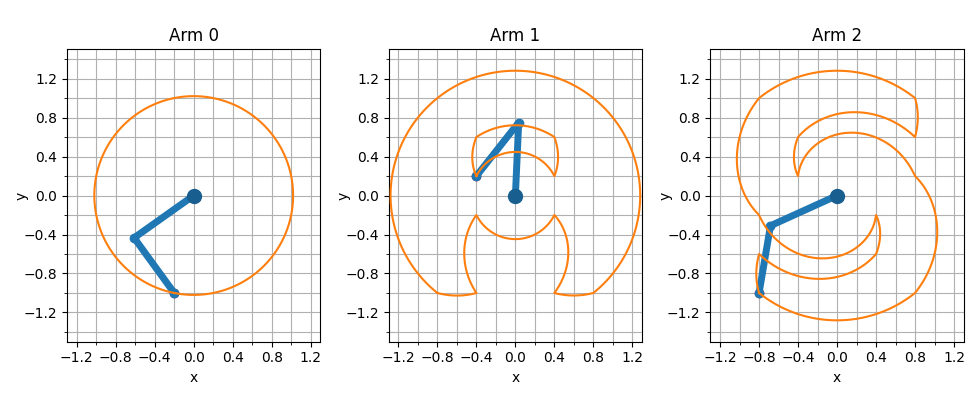

In [22]:
fig, axes = setup_axes(3)
for letter, ax in zip("IAS", axes):
    # Create robot arm with your kinematics model
    # Feel free to change the joint velocity to speed up/slow down the robot
    arm = RobotArm(fig, ax, l, compute_forward_kinematics_analytical, joint_vel=1.0)
    
    # Set initial joint position
    arm.set_joint_pos(np.array([-0.5, 0.5]) * np.pi)
    
    # Iterate over the corner coordinates you generated
    points = get_letter_print_path(letter)
    for pt, extrude in points:
        # The red marker indicates where the current target end effector position is
        arm.target_position_marker = pt
        
        # Call your inverse kinematics function to obtain the target joint positions
        q_target = compute_inverse_kinematics_newton(np.array(pt), arm.l, arm.q)
        
        # Move to the target joint positions with constant joint velocity
        arm.move_to_joint_pos(q_target, extrude)
        time.sleep(0.2)

Dies ist offensichtlich noch kein zufriedenstellendes Ergebnis. 
Das Problem ist, dass wir zwar die Eckkoordinaten der Buchstaben korrekt anfahren können, allerdings der Weg dorthin keineswegs gradlinig verläuft.
In den nächsten Aufgaben befassen wir uns damit, wie man dieses Problem beheben kann.

## 8. Begradigung der Teilstrecken durch Zwischenziele

In [23]:
def compute_via_points(start_pos: np.ndarray, target_pos: np.ndarray, max_step_size: float) -> np.ndarray:
    """
    Splits the straight line from start_pos to target_pos into consecutive segments of a length not greater
    than max_step_size. The number of segments must be chosen as small as possible while ensuring each
    segment is not longer than max_step_size. The function is expected to return a list of 2D points,
    where the first point is start_pos and the last point is end_pos. Every intermediate point (via-point)
    marks the end of the previous segment and the beginning of the next segment.
    :param start_pos:       A 2D numpy array containing the starting position of the path.
    :param target_pos:      A 2D numpy array containing the end position of the path.
    :param max_step_size:   The maximum distance between two via-points.
    :return: A nx2 numpy array containing the via points, where n is the number of via-points.
    """
    # Implement this...
    segments = np.ceil(np.divide(np.linalg.norm(target_pos-start_pos), max_step_size))
    points = np.empty((segments.astype(int)+1, 2))
    for i in range(segments.astype(int)+1):
        points[i] = (np.dot(np.divide(target_pos[0]-start_pos[0],segments),i)+start_pos[0],
                     np.dot(np.divide(target_pos[1]-start_pos[1],segments),i)+start_pos[1])
    return points


### Öffentliche Tests

In [24]:
test_cases = [
    ([0., 0.],    [0., 1.0],   0.2),
    ([1.0, 0.],   [-1.0, 0.],  0.2),
    ([0.7, -0.3], [0.7, 0.7],  0.2),
    ([-0.4, 0.1], [-0.1, 1.2], 0.3),
    ([0.6, -0.9], [-0.4, 1.2], 0.01),
    ([0.1, 0.3],  [0., 0.],    0.5)]


for i, (start_pos, target_pos, max_step_size) in enumerate(test_cases):
    start_pos = np.array(start_pos)
    target_pos = np.array(target_pos)
    
    # Execute your function
    via_points = compute_via_points(start_pos, target_pos, max_step_size)
    
    # Tests
    # Start and target have to be in the list
    test_almost_zero("{}.1".format(i), np.linalg.norm(start_pos - via_points[0]))
    test_almost_zero("{}.2".format(i), np.linalg.norm(target_pos - via_points[-1]))

    # All points have to be on the direct line between start and target
    direction = target_pos - start_pos
    direction /= np.linalg.norm(direction)
    closest_points_on_line = ((via_points - start_pos) @ direction)[:, np.newaxis] * direction[np.newaxis] + start_pos
    distances_to_line = np.linalg.norm(via_points - closest_points_on_line, axis=-1)
    test_almost_zero("{}.3".format(i), np.max(distances_to_line))

    # The distance between the points must be smaller or equal max_step_size
    point_dist = np.linalg.norm(via_points[1:] - via_points[:-1], axis=-1)
    test_geq("{}.4".format(i), max_step_size, np.max(point_dist))

    # The distances to the target must be strictly decreasing
    distances_to_target = np.linalg.norm(target_pos - via_points, axis=-1)
    test_true("{}.5".format(i), np.all(distances_to_target[:-1] > distances_to_target[1:]))

    # There should not be more via-points than necessary
    test_geq("{}.6".format(i), np.linalg.norm(target_pos - start_pos) / max_step_size + 2, len(via_points))
    

Test 0.1: passed.
Test 0.2: passed.
Test 0.3: passed.
Test 0.4: passed.
Test 0.5: passed.
Test 0.6: passed.
Test 1.1: passed.
Test 1.2: passed.
Test 1.3: passed.
Test 1.4: passed.
Test 1.5: passed.
Test 1.6: passed.
Test 2.1: passed.
Test 2.2: passed.
Test 2.3: passed.
Test 2.4: passed.
Test 2.5: passed.
Test 2.6: passed.
Test 3.1: passed.
Test 3.2: passed.
Test 3.3: passed.
Test 3.4: passed.
Test 3.5: passed.
Test 3.6: passed.
Test 4.1: passed.
Test 4.2: passed.
Test 4.3: passed.
Test 4.4: passed.
Test 4.5: passed.
Test 4.6: passed.
Test 5.1: passed.
Test 5.2: passed.
Test 5.3: passed.
Test 5.4: passed.
Test 5.5: passed.
Test 5.6: passed.


### Buchstaben drucken

<IPython.core.display.Javascript object>


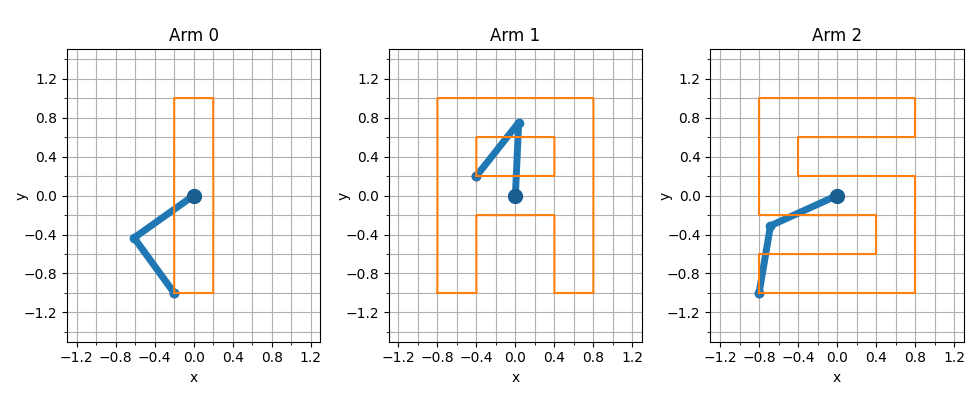

In [25]:
fig, axes = setup_axes(3)
for letter, ax in zip("IAS", axes):
    # Create robot arm with your kinematics model
    # Feel free to change the joint velocity to speed up/slow down the robot
    arm = RobotArm(fig, ax, l, compute_forward_kinematics_analytical, joint_vel=3.0)
    
    # Set initial joint position
    arm.set_joint_pos(np.array([-0.5, 0.5]) * np.pi)
    
    # Iterate over the corner coordinates you generated
    points = get_letter_print_path(letter)
    for pt, extrude in points:
        # The red marker indicates where the current target end effector position is
        arm.target_position_marker = pt
        
        # Call your kinematics function to obtain the current end effector position
        current_pos = compute_forward_kinematics_analytical(arm.q, arm.l)[1]
        
        # Call your function to obtain via-points 
        via_points = compute_via_points(current_pos, np.array(pt), 0.05)
        for pt_via in via_points:
            # Move to each via-point with constant joint velocity
            q_target = compute_inverse_kinematics_newton(pt_via, arm.l, arm.q)
            arm.move_to_joint_pos(q_target, extrude)
        time.sleep(0.2)

## 9. Bonus: Eine elegantere Lösung

In [ ]:
def compute_joint_vel(q: np.ndarray, l: np.ndarray, target_vel: np.ndarray) -> np.ndarray:
    """
    Given a target linear end effector velocity, computes joint velocities that have to be
    assumed to reach the desired end effector velocity.
    :param q:           2D numpy array containing the joint angles in radians.
    :param l:           2D numpy array containing the link length in meters.
    :param target_vel:  2D numpy array containing the target end effector velocity in m/s.
    :return: A 2D numpy array containing the calculated joint velocities for both joints.
    """
    # Implement this...
    return np.zeros(2)


### Öffentliche Tests

In [ ]:
test_cases = [
    (([0.785398, 1.570796], [1.0, -1.0]), [-1.885618, 1.885618]),
    (([-2.617994, 0.523599], [0.5, 0.2]), [-1.128547, 2.65144]),
    (([0., -2.617994], [-0.7, -0.1]), [-1.749914, -0.250086]),
    (([-2.094395, -1.047198], [0., -0.4]), [0.0, 0.571429]),
    (([-0.785398, 2.356194], [0., 0.]), [0., 0.0]),
    (([10.053096, -2.094395], [-0.3, 0.6]), [-0.96698, 0.785583])]
l = np.array([0.75, 0.7])


for i, ((q, v), vq_tar) in enumerate(test_cases):
    # Execute your function
    vq = compute_joint_vel(np.array(q), l, np.array(v))
    
    test_almost_zero(i, np.linalg.norm(vq - vq_tar))
    

### Elegantes Drucken

In [ ]:
# Target linear end effector velocity
# Feel free to fiddle with this value to speed up/slow down the printing (bear in mind though 
# that accuracy will deteriorate if you set it too high due to the discrete control time step)
target_vel = 1.0

fig, axes = setup_axes(3)
for letter, ax in zip("IAS", axes):
    # Create robot arm with your kinematics model
    # Feel free to change the joint velocity to speed up/slow down the robot
    arm = RobotArm(fig, ax, l, compute_forward_kinematics_analytical, joint_vel=3.0)
    
    # Set initial joint position
    arm.set_joint_pos(np.array([-0.5, 0.5]) * np.pi)
    
    # Iterate over the corner coordinates you generated
    points = get_letter_print_path(letter)
    for pt, extrude in points:
        # The red marker indicates where the current target end effector position is
        arm.target_position_marker = pt
        
        # Call your kinematics function to obtain the current end effector position
        current_pos = compute_forward_kinematics_analytical(arm.q, arm.l)[1]
        
        while np.linalg.norm(pt - current_pos) > 1e-4:
            # Compute target end effector velocity
            diff = pt - current_pos
            distance = np.linalg.norm(pt - current_pos)
            target_vel_clipped = min(target_vel, distance / arm.dt)  # Make sure we do not overshoot
            target_vel_vec = target_vel_clipped * diff / distance
            
            # Call your function to obtain target joint velocities
            q_vel = compute_joint_vel(arm.q, arm.l, target_vel_vec)
            
            # Set joint velocities in robot
            arm.step_vel(q_vel, extrude)
            
            # Update the current end effector position using your kinematics function
            current_pos = compute_forward_kinematics_analytical(arm.q, arm.l)[1]
        arm.render()
